In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, GATConv, TransformerConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.loader import DataLoader
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# 1. Positional Encoding for Graph Nodes: GraphPositionalEncoding
class GraphPositionalEncoding(nn.Module):
    """
    Add positional encoding to graph nodes (temporal + spatial)
    """
    def __init__(self, d_model, max_nodes=1000, max_time=500):
        super().__init__()
        self.d_model = d_model

        # Temporal positional encoding
        self.temporal_pe = nn.Parameter(torch.zeros(max_time, d_model // 2))

        # Spatial positional encoding (learnable)
        self.spatial_pe = nn.Parameter(torch.zeros(max_nodes, d_model // 2))

        self._init_positional_encoding()

    def _init_positional_encoding(self):
        """Initialize with sinusoidal encoding"""
        max_time = self.temporal_pe.shape[0]
        d_model = self.temporal_pe.shape[1]

        position = torch.arange(0, max_time, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))

        self.temporal_pe.data[:, 0::2] = torch.sin(position * div_term)
        self.temporal_pe.data[:, 1::2] = torch.cos(position * div_term)

        # Initialize spatial randomly (will be learned)
        nn.init.normal_(self.spatial_pe, mean=0, std=0.02)

    def forward(self, x, node_ids, time_ids):
        """
        Args:
            x: (num_nodes, feature_dim)
            node_ids: (num_nodes,) - spatial node identifiers
            time_ids: (num_nodes,) - temporal timestep identifiers
        """
        batch_size = x.shape[0]

        # Get temporal and spatial encodings
        temporal_enc = self.temporal_pe[time_ids]  # (num_nodes, d_model//2)
        spatial_enc = self.spatial_pe[node_ids]    # (num_nodes, d_model//2)

        # Concatenate temporal and spatial
        pe = torch.cat([temporal_enc, spatial_enc], dim=-1)  # (num_nodes, d_model)

        return pe




In [24]:
# 2. Graph Transformer Encoder Layer: GraphTransformerLayer
class GraphTransformerLayer(nn.Module):
    """
    Transformer layer that operates on graph structure
    Combines GNN message passing with transformer attention
    (Basically sparser version of multiheaded transformer over the actual spatial network)
    """
    def __init__(self, d_model, nhead=8, dim_feedforward=2048, dropout=0.1):
        super().__init__()

        # Graph convolution for local structure
        self.graph_conv = GATConv(d_model, d_model, heads=nhead,
                                   concat=False, dropout=dropout)

        # Self-attention for global dependencies
        self.self_attn = nn.MultiheadAttention(d_model, nhead,
                                               dropout=dropout, batch_first=True)

        # Feedforward network
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch, edge_attr=None):
        """
        Args:
            x: (num_nodes, d_model) - node features
            edge_index: (2, num_edges) - graph connectivity
            batch: (num_nodes,) - batch assignment
            edge_attr: (num_edges, edge_dim) - edge features
        """
        # Graph convolution for local structure
        x2 = self.graph_conv(x, edge_index, edge_attr)
        x = x + self.dropout1(x2)
        x = self.norm1(x)

        # Self-attention for global context
        # Group nodes by graph for attention
        batch_size = batch.max().item() + 1
        max_nodes = max([(batch == i).sum() for i in range(batch_size)])

        # Create padded batch for attention
        x_batched = torch.zeros(batch_size, max_nodes, x.shape[1],
                               device=x.device)
        mask = torch.ones(batch_size, max_nodes, dtype=torch.bool,
                         device=x.device)

        for i in range(batch_size):
            nodes_in_graph = (batch == i).sum()
            x_batched[i, :nodes_in_graph] = x[batch == i]
            mask[i, :nodes_in_graph] = False

        # Apply self-attention
        x_attn, _ = self.self_attn(x_batched, x_batched, x_batched,
                                    key_padding_mask=mask)

        # Unpack back to node format
        x_attn_unpacked = torch.zeros_like(x)
        for i in range(batch_size):
            nodes_in_graph = (batch == i).sum()
            x_attn_unpacked[batch == i] = x_attn[i, :nodes_in_graph]

        x = x + self.dropout2(x_attn_unpacked)
        x = self.norm2(x)

        # Feedforward
        x2 = self.linear2(self.dropout(F.gelu(self.linear1(x))))
        x = x + self.dropout3(x2)
        x = self.norm3(x)

        return x



In [25]:
# 3. Spatiotemporal Graph Transformer
class SpatiotemporalGraphTransformer(nn.Module):
    """
    Main model: Embeds spatiotemporal graphs using transformer architecture
    
    """
    def __init__(self, node_feature_dim, d_model=256, nhead=8,
                 num_layers=6, dim_feedforward=1024, dropout=0.1,
                 num_classes=None, max_nodes=1000, max_time=500,
                 use_layer_norm=True, use_dropout=True):
        super().__init__()

        self.d_model = d_model
        self.num_classes = num_classes
        self.use_dropout = use_dropout

        # Input projection with dropout
        self.input_proj = nn.Sequential(
            nn.Linear(node_feature_dim, d_model),
            nn.LayerNorm(d_model) if use_layer_norm else nn.Identity(),
            nn.Dropout(dropout) if use_dropout else nn.Identity()
        )

        # Positional encoding
        self.pos_encoder = GraphPositionalEncoding(d_model, max_nodes, max_time)

        # Transformer layers
        self.layers = nn.ModuleList([
            GraphTransformerLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        # Pooling types for graph-level representation
        self.pooling_type = 'attention'  # 'mean', 'max', 'attention', 'hierarchical'

        if self.pooling_type == 'attention':
            self.attention_pool = nn.Sequential(
                nn.Linear(d_model, d_model // 2),
                nn.Tanh(),
                nn.Dropout(dropout),
                nn.Linear(d_model // 2, 1)
            )

        # Classification head (if num_classes provided) with stronger regularization
        if num_classes is not None:
            self.classifier = nn.Sequential(
                nn.Linear(d_model, d_model // 2),
                nn.LayerNorm(d_model // 2),
                nn.ReLU(),
                nn.Dropout(dropout * 1.5),  # Stronger dropout
                nn.Linear(d_model // 2, d_model // 4),
                nn.LayerNorm(d_model // 4),
                nn.ReLU(),
                nn.Dropout(dropout * 1.5),
                nn.Linear(d_model // 4, num_classes)
            )

    def forward(self, data, return_embeddings=False):
        """
        Args:
            data: PyG Data/Batch object with:
                - x: (num_nodes, node_feature_dim)
                - edge_index: (2, num_edges)
                - batch: (num_nodes,)
                - node_ids: (num_nodes,) - spatial identifiers
                - time_ids: (num_nodes,) - temporal identifiers
                - edge_attr: (num_edges, edge_dim) - optional
        Returns:
            logits: (batch_size, num_classes) or embeddings: (batch_size, d_model)
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') else None

        # Input projection
        x = self.input_proj(x)  # (num_nodes, d_model)

        # Add positional encoding
        if hasattr(data, 'node_ids') and hasattr(data, 'time_ids'):
            pos_enc = self.pos_encoder(x, data.node_ids, data.time_ids)
            x = x + pos_enc

        # Pass through transformer layers
        for layer in self.layers:
            x = layer(x, edge_index, batch, edge_attr)

        # Graph-level pooling
        graph_embeddings = self._pool_graph(x, batch)

        if return_embeddings:
            return graph_embeddings

        # Classification
        if self.num_classes is not None:
            logits = self.classifier(graph_embeddings)
            return logits

        return graph_embeddings

    def _pool_graph(self, x, batch):
        """Pool node features to graph-level representation"""
        if self.pooling_type == 'mean':
            return global_mean_pool(x, batch)

        elif self.pooling_type == 'max':
            return global_max_pool(x, batch)

        elif self.pooling_type == 'attention':
            # Attention-based pooling
            attention_scores = self.attention_pool(x)  # (num_nodes, 1)

            batch_size = batch.max().item() + 1
            graph_embeddings = []

            for i in range(batch_size):
                mask = (batch == i)
                node_features = x[mask]  # (nodes_in_graph, d_model)
                scores = attention_scores[mask]  # (nodes_in_graph, 1)

                # Softmax over nodes in this graph
                weights = F.softmax(scores, dim=0)

                # Weighted sum
                graph_emb = (node_features * weights).sum(dim=0)
                graph_embeddings.append(graph_emb)

            return torch.stack(graph_embeddings)

        else:
            raise ValueError(f"Unknown pooling type: {self.pooling_type}")



In [26]:
# 4. Dataset for Spatiotemporal Graphs: SpatiotemporalGraphDataset
class SpatiotemporalGraphDataset(torch.utils.data.Dataset):
    """
    Dataset for spatiotemporal graphs with temporal snapshots
    """
    def __init__(self, graphs, labels=None):
        """
        Args:
            graphs: List of Data objects or list of (node_features, edge_index, ...)
            labels: List of labels for classification
        """
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        if isinstance(self.graphs[idx], Data):
            graph = self.graphs[idx]
        else:
            # Construct Data object if needed
            graph = self._construct_graph(self.graphs[idx])

        if self.labels is not None:
            graph.y = torch.tensor([self.labels[idx]], dtype=torch.long)

        return graph

    def _construct_graph(self, graph_data):
        """Construct PyG Data object from raw data"""
        # Implement based on your data format
        pass


In [27]:
# 5. Training Pipeline: train_epoch
def train_epoch(model, dataloader, optimizer, criterion, device, epoch=None):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Create progress bar
    pbar = tqdm(dataloader, desc=f'Epoch {epoch} [Train]' if epoch else 'Training',
                leave=True, ncols=100)

    for batch_idx, batch in enumerate(pbar):
        batch = batch.to(device)

        # Forward pass
        logits = model(batch)
        loss = criterion(logits, batch.y.squeeze())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (important for stability on MPS)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Metrics - move to CPU for accumulation (avoids MPS memory issues)
        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == batch.y.squeeze()).sum().item()
        total += batch.y.size(0)

        # Update progress bar
        current_loss = total_loss / (batch_idx + 1)
        current_acc = correct / total
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.4f}'
        })

        # Clear cache periodically on MPS to avoid memory issues
        if device.type == 'mps' and total % 100 == 0:
            torch.mps.empty_cache()

    pbar.close()
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy


In [28]:
# model evaluator: evaluate
@torch.no_grad()
def evaluate(model, dataloader, criterion, device, epoch=None, split='Val'):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    # Create progress bar
    pbar = tqdm(dataloader, desc=f'Epoch {epoch} [{split}]' if epoch else f'{split}',
                leave=True, ncols=100)

    for batch_idx, batch in enumerate(pbar):
        batch = batch.to(device)

        logits = model(batch)
        loss = criterion(logits, batch.y.squeeze())

        # Move metrics to CPU
        total_loss += loss.item()
        pred = logits.argmax(dim=1)
        correct += (pred == batch.y.squeeze()).sum().item()
        total += batch.y.size(0)

        # Update progress bar
        current_loss = total_loss / (batch_idx + 1)
        current_acc = correct / total
        pbar.set_postfix({
            'loss': f'{current_loss:.4f}',
            'acc': f'{current_acc:.4f}'
        })

        # Clear cache on MPS
        if device.type == 'mps':
            torch.mps.empty_cache()

    pbar.close()
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy



In [29]:
# 6. Complete Training Pipeline: create_example_data
def create_example_data(num_graphs=1000, num_nodes=50, num_timesteps=10,
                       node_feature_dim=32, num_classes=5):
    """
    Create example spatiotemporal graph data
    Each graph represents a trajectory with temporal snapshots
    """
    graphs = []
    labels = []

    for _ in range(num_graphs):
        # Create temporal graph
        total_nodes = num_nodes * num_timesteps

        # Node features (num_nodes * num_timesteps, feature_dim)
        x = torch.randn(total_nodes, node_feature_dim)

        # Create spatiotemporal edges
        edge_index = []

        # Spatial edges (within each timestep)
        for t in range(num_timesteps):
            offset = t * num_nodes
            for i in range(num_nodes):
                # Connect to spatial neighbors
                neighbors = [(i + 1) % num_nodes, (i - 1) % num_nodes]
                for j in neighbors:
                    edge_index.append([offset + i, offset + j])

        # Temporal edges (across timesteps)
        for t in range(num_timesteps - 1):
            for i in range(num_nodes):
                curr_idx = t * num_nodes + i
                next_idx = (t + 1) * num_nodes + i
                edge_index.append([curr_idx, next_idx])
                edge_index.append([next_idx, curr_idx])  # bidirectional

        edge_index = torch.tensor(edge_index, dtype=torch.long).t()

        # Node and time IDs
        node_ids = torch.arange(num_nodes).repeat(num_timesteps)
        time_ids = torch.arange(num_timesteps).repeat_interleave(num_nodes)

        # Create Data object
        data = Data(x=x, edge_index=edge_index,
                   node_ids=node_ids, time_ids=time_ids)

        graphs.append(data)
        labels.append(torch.randint(0, num_classes, (1,)).item())

    return graphs, labels


In [1]:
# 7. Graph Visualization Tools: GraphVisualizer
class GraphVisualizer:
    """
    Visualize spatiotemporal graphs and model predictions
    """
    def __init__(self, figsize=(15, 10)):
        self.figsize = figsize

    def visualize_graph_structure(self, data, title="Graph Structure",
                                  save_path=None, node_colors=None,
                                  edge_colors=None, show_node_ids=True):
        """
        Visualize the graph structure in 2D/3D

        Args:
            data: PyG Data object
            title: Plot title
            save_path: Path to save figure
            node_colors: Custom node colors (array-like)
            edge_colors: Custom edge colors (array-like)
            show_node_ids: Whether to show node ID labels
        """
        try:
            import matplotlib.pyplot as plt
            import networkx as nx
        except ImportError:
            print("Matplotlib and NetworkX required for visualization")
            return

        # Convert to NetworkX graph
        G = self._to_networkx(data)

        fig, axes = plt.subplots(1, 2, figsize=self.figsize)
        fig.suptitle(title, fontsize=16)

        # Layout 1: Spring layout (force-directed)
        pos_spring = nx.spring_layout(G, seed=42)

        # Layout 2: Temporal layout (if time_ids available)
        if hasattr(data, 'time_ids') and hasattr(data, 'node_ids'):
            pos_temporal = self._temporal_layout(data)
        else:
            pos_temporal = nx.kamada_kawai_layout(G)

        # Determine node colors
        if node_colors is None:
            if hasattr(data, 'time_ids'):
                node_colors = data.time_ids.numpy()
            else:
                node_colors = 'lightblue'

        # Plot 1: Spring layout
        nx.draw_networkx_nodes(G, pos_spring, node_color=node_colors,
                              node_size=300, cmap='viridis', ax=axes[0])
        nx.draw_networkx_edges(G, pos_spring, alpha=0.3,
                              edge_color=edge_colors if edge_colors is not None else 'gray',
                              ax=axes[0])
        if show_node_ids:
            nx.draw_networkx_labels(G, pos_spring, font_size=8, ax=axes[0])
        axes[0].set_title('Force-Directed Layout')
        axes[0].axis('off')

        # Plot 2: Temporal layout
        nx.draw_networkx_nodes(G, pos_temporal, node_color=node_colors,
                              node_size=300, cmap='viridis', ax=axes[1])
        nx.draw_networkx_edges(G, pos_temporal, alpha=0.3,
                              edge_color=edge_colors if edge_colors is not None else 'gray',
                              ax=axes[1])
        if show_node_ids:
            nx.draw_networkx_labels(G, pos_temporal, font_size=8, ax=axes[1])
        axes[1].set_title('Temporal Layout')
        axes[1].axis('off')

        # Add colorbar for time
        if hasattr(data, 'time_ids'):
            sm = plt.cm.ScalarMappable(cmap='viridis',
                                      norm=plt.Normalize(vmin=data.time_ids.min().item(),
                                                        vmax=data.time_ids.max().item()))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axes, fraction=0.046, pad=0.04)
            cbar.set_label('Timestep', rotation=270, labelpad=20)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Graph visualization saved to {save_path}")

        return fig

    def visualize_spatiotemporal_3d(self, data, title="Spatiotemporal Graph",
                                   save_path=None, node_feature_idx=0):
        """
        3D visualization of spatiotemporal graph
        Node positions: (time, spatial_x, node_feature)
        """
        try:
            import matplotlib.pyplot as plt
            from mpl_toolkits.mplot3d import Axes3D
        except ImportError:
            print("Matplotlib with 3D support required")
            return

        if not hasattr(data, 'time_ids') or not hasattr(data, 'node_ids'):
            print("Data must have time_ids and node_ids for 3D visualization")
            return

        fig = plt.figure(figsize=self.figsize)
        ax = fig.add_subplot(111, projection='3d')

        # Get node positions
        time_ids = data.time_ids.numpy()
        node_ids = data.node_ids.numpy()
        feature_values = data.x[:, node_feature_idx].numpy()

        # Plot nodes
        scatter = ax.scatter(time_ids, node_ids, feature_values,
                           c=time_ids, cmap='viridis', s=50, alpha=0.6)

        # Plot edges
        edge_index = data.edge_index.numpy()
        for i in range(edge_index.shape[1]):
            src, dst = edge_index[:, i]
            ax.plot([time_ids[src], time_ids[dst]],
                   [node_ids[src], node_ids[dst]],
                   [feature_values[src], feature_values[dst]],
                   'gray', alpha=0.2, linewidth=0.5)

        ax.set_xlabel('Time')
        ax.set_ylabel('Spatial Node ID')
        ax.set_zlabel(f'Feature {node_feature_idx}')
        ax.set_title(title)

        plt.colorbar(scatter, ax=ax, label='Timestep', shrink=0.5)

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"3D visualization saved to {save_path}")

        return fig

    def visualize_attention_flow(self, data, attention_weights, title="Attention Flow",
                                save_path=None, top_k=20):
        """
        Visualize attention weights as edge thickness in graph

        Args:
            data: PyG Data object
            attention_weights: Attention matrix (num_nodes, num_nodes) or edge weights
            top_k: Show only top-k strongest attention connections
        """
        try:
            import matplotlib.pyplot as plt
            import networkx as nx
        except ImportError:
            print("Matplotlib and NetworkX required")
            return

        fig, ax = plt.subplots(figsize=self.figsize)

        # Convert to NetworkX
        G = self._to_networkx(data)

        # Create layout
        if hasattr(data, 'time_ids') and hasattr(data, 'node_ids'):
            pos = self._temporal_layout(data)
        else:
            pos = nx.spring_layout(G, seed=42)

        # Process attention weights
        if attention_weights.dim() == 2:
            # Full attention matrix
            attention_flat = attention_weights.flatten()
        else:
            # Edge-wise attention
            attention_flat = attention_weights.flatten()

        # Get top-k edges by attention
        if len(attention_flat) > top_k:
            threshold = torch.topk(attention_flat, top_k).values[-1]
            strong_edges = attention_flat >= threshold
        else:
            strong_edges = torch.ones_like(attention_flat, dtype=torch.bool)

        # Draw nodes
        node_colors = data.time_ids.numpy() if hasattr(data, 'time_ids') else 'lightblue'
        nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                              node_size=300, cmap='viridis', ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

        # Draw all edges faintly
        nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='gray', ax=ax)

        # Draw high-attention edges
        edge_index = data.edge_index.numpy()
        for i, is_strong in enumerate(strong_edges[:edge_index.shape[1]]):
            if is_strong:
                src, dst = edge_index[:, i]
                ax.annotate('', xy=pos[dst], xytext=pos[src],
                           arrowprops=dict(arrowstyle='->', color='red',
                                         lw=2, alpha=0.6))

        ax.set_title(f"{title} (Top {top_k} connections)")
        ax.axis('off')

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Attention flow saved to {save_path}")

        return fig

    def visualize_prediction_comparison(self, data, true_labels, pred_labels,
                                       title="Predictions vs Ground Truth",
                                       save_path=None):
        """
        Compare predictions with ground truth on the graph structure
        """
        try:
            import matplotlib.pyplot as plt
            import networkx as nx
        except ImportError:
            print("Matplotlib and NetworkX required")
            return

        fig, axes = plt.subplots(1, 2, figsize=self.figsize)
        fig.suptitle(title, fontsize=16)

        G = self._to_networkx(data)

        if hasattr(data, 'time_ids') and hasattr(data, 'node_ids'):
            pos = self._temporal_layout(data)
        else:
            pos = nx.spring_layout(G, seed=42)

        # Plot ground truth
        nx.draw_networkx_nodes(G, pos, node_color='lightblue',
                              node_size=500, ax=axes[0])
        nx.draw_networkx_edges(G, pos, alpha=0.3, ax=axes[0])
        axes[0].set_title(f'Ground Truth: Class {true_labels.item()}')
        axes[0].axis('off')

        # Plot prediction (color nodes by confidence if available)
        correct = (pred_labels == true_labels).item()
        node_color = 'lightgreen' if correct else 'lightcoral'
        nx.draw_networkx_nodes(G, pos, node_color=node_color,
                              node_size=500, ax=axes[1])
        nx.draw_networkx_edges(G, pos, alpha=0.3, ax=axes[1])
        axes[1].set_title(f'Prediction: Class {pred_labels.item()} {"✓" if correct else "✗"}')
        axes[1].axis('off')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Prediction comparison saved to {save_path}")

        return fig

    def _to_networkx(self, data):
        """Convert PyG Data to NetworkX graph"""
        import networkx as nx

        G = nx.Graph()
        G.add_nodes_from(range(data.x.shape[0]))

        edge_index = data.edge_index.numpy()
        edges = [(edge_index[0, i], edge_index[1, i])
                 for i in range(edge_index.shape[1])]
        G.add_edges_from(edges)

        return G

    def _temporal_layout(self, data):
        """Create layout based on temporal and spatial structure"""
        num_nodes = data.x.shape[0]
        pos = {}

        time_ids = data.time_ids.numpy()
        node_ids = data.node_ids.numpy()

        # Normalize positions
        max_time = time_ids.max()
        max_node = node_ids.max()

        for i in range(num_nodes):
            x = time_ids[i] / max_time * 10  # Horizontal: time
            y = node_ids[i] / max_node * 10  # Vertical: spatial node
            pos[i] = (x, y)

        return pos



In [31]:
# Set configuration and create example data
num_graphs = 1000
num_nodes = 30  # nodes per timestep
num_timesteps = 10
node_feature_dim = 32
num_classes = 5
d_model = 256
batch_size = 32
num_epochs = 10 # Demo

# Device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: CUDA ({torch.cuda.get_device_name(0)})")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using device: MPS (Apple Silicon)")
else:
    device = torch.device('cpu')
    print(f"Using device: CPU")

# MPS-specific optimizations
if device.type == 'mps':
    # Disable some features that may not be stable on MPS
    torch.backends.mps.enable_fallback = True
    print("  MPS fallback enabled for unsupported operations")

# Create example data
print("Creating example spatiotemporal graphs...")
graphs, labels = create_example_data(
    num_graphs=num_graphs,
    num_nodes=num_nodes,
    num_timesteps=num_timesteps,
    node_feature_dim=node_feature_dim,
    num_classes=num_classes
)


Using device: MPS (Apple Silicon)
  MPS fallback enabled for unsupported operations
Creating example spatiotemporal graphs...


In [32]:
# Split data
train_size = int(0.7 * len(graphs))
val_size = int(.15 * len(graphs))
train_graphs = graphs[:train_size]
train_labels = labels[:train_size]
val_graphs = graphs[train_size:train_size+val_size]
val_labels = labels[train_size:train_size+val_size]
test_graphs = graphs[train_size+val_size:]
test_labels = labels[train_size+val_size:]


# Create datasets
train_dataset = SpatiotemporalGraphDataset(train_graphs, train_labels)
val_dataset = SpatiotemporalGraphDataset(val_graphs, val_labels)
test_dataset = SpatiotemporalGraphDataset(test_graphs, test_labels)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



GRAPH VISUALIZATION

1. Visualizing graph structure...


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_94547/2931726682.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Graph visualization saved to graph_structure.png

2. Creating 3D spatiotemporal visualization...
3D visualization saved to graph_3d.png


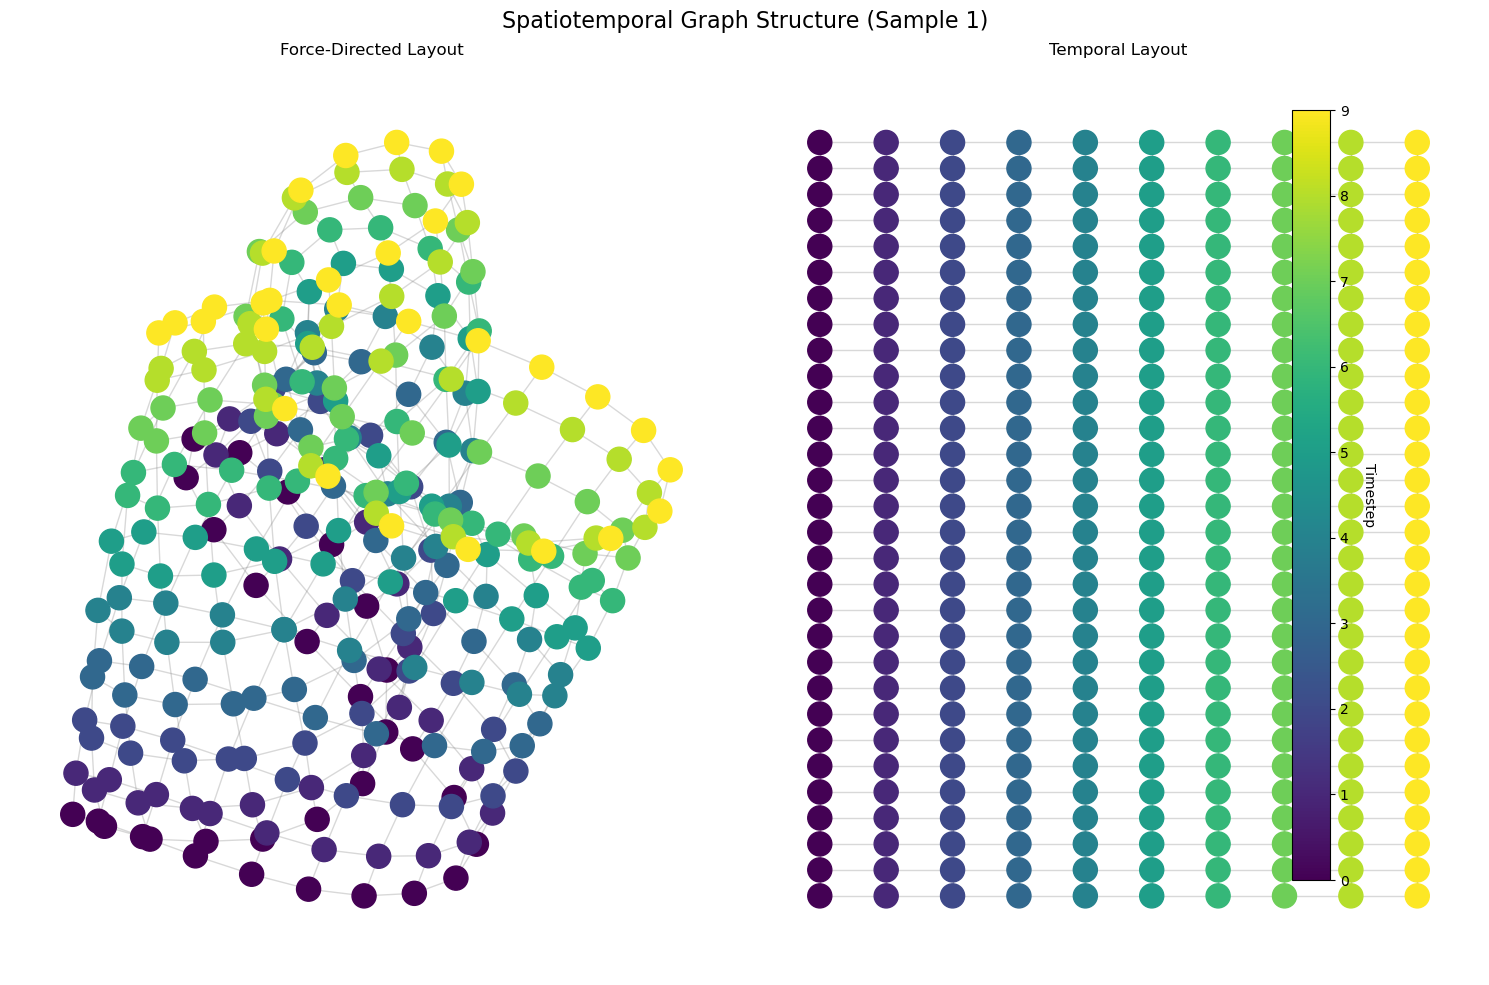

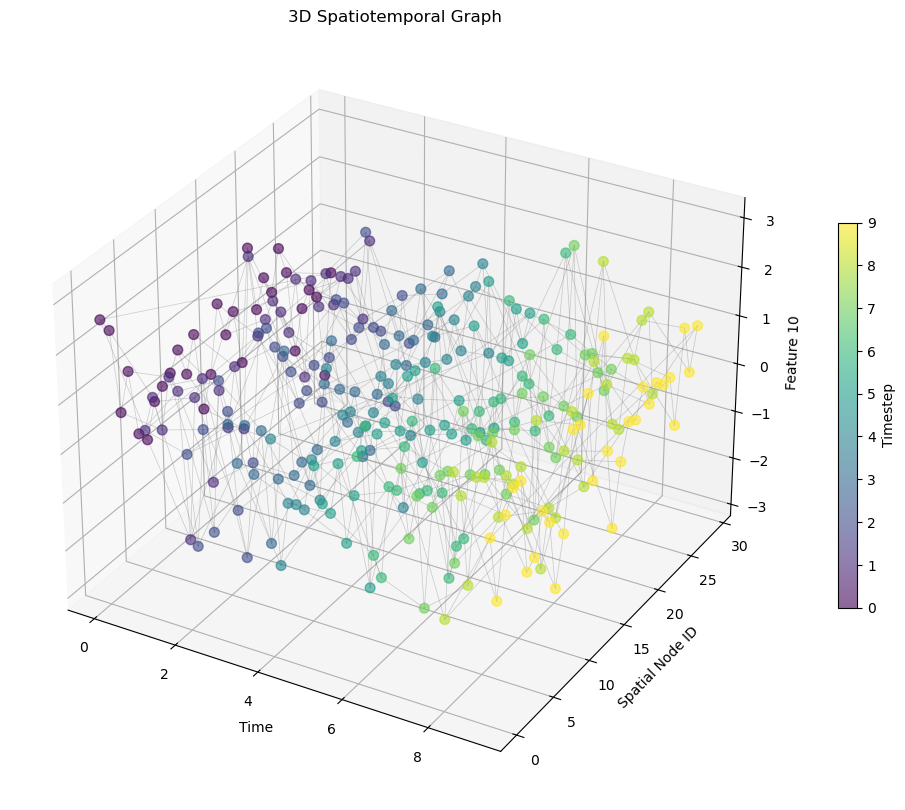

In [33]:
# Example visualization usage

print("\n" + "="*60)
print("GRAPH VISUALIZATION")
print("="*60)

# Create visualizer
visualizer = GraphVisualizer(figsize=(15, 10))

# Get sample data
sample_idx = 1
sample_data = graphs[sample_idx]
sample_batch = Batch.from_data_list([sample_data]).to(device)

print("\n1. Visualizing graph structure...")
fig1 = visualizer.visualize_graph_structure(
    sample_data,
    title=f"Spatiotemporal Graph Structure (Sample {sample_idx})",
    save_path="graph_structure.png",
    show_node_ids=False
)

print("\n2. Creating 3D spatiotemporal visualization...")
fig2 = visualizer.visualize_spatiotemporal_3d(
    sample_data,
    title="3D Spatiotemporal Graph",
    save_path="graph_3d.png",
    node_feature_idx=10
)

In [34]:
# Initialize model with regularization
model = SpatiotemporalGraphTransformer(
    node_feature_dim=node_feature_dim,
    d_model=d_model,
    nhead=4,  # Reduced from 8
    num_layers=3,  # Reduced from 4
    dim_feedforward=d_model * 2,  # Reduced from d_model * 4
    dropout=0.3,  # Increased from 0.1
    num_classes=num_classes,
    max_nodes=num_nodes,
    max_time=num_timesteps,
    use_layer_norm=True,
    use_dropout=True
).to(device)

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,  # Reduced from 1e-4
    weight_decay=0.01,  # L2 regularization
    betas=(0.9, 0.999)
)

# Label smoothing for better generalization
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Learning rate scheduler - more aggressive
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
)

# Early stopping
# early_stopping = EarlyStopping(patience=15, min_delta=0.001, mode='min')



Model parameters: 2,465,158


In [35]:
# Training loop
print("\nStarting training with early stopping...")
print("="*70)
best_val_loss = float('inf')
best_val_acc = 0.0

# Training history for plotting
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, criterion, device, epoch=epoch+1
    )

    # Validate
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device, epoch=epoch+1, split='Val'
    )

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    improvement = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        # Save to CPU for compatibility
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'history': history
        }, 'best_model.pt')
        improvement = "✓ New best!"

    # Calculate overfitting metric
    overfit_gap = train_acc - val_acc
    overfit_warning = " ⚠ Overfitting!" if overfit_gap > 0.15 else ""

    # Print epoch summary
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train → Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"  Val   → Loss: {val_loss:.4f} | Acc: {val_acc:.4f} {improvement}")
    print(f"  Gap   → {overfit_gap:.4f}{overfit_warning}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"{'='*70}\n")

    # Early stopping check @TODO: need to implement
    # if early_stopping(val_loss, epoch):
    #     print(f"\n{'='*70}")
    #     print(f"Early stopping triggered after epoch {epoch+1}")
    #     print(f"Best epoch was {early_stopping.best_epoch+1} with val_loss={early_stopping.best_score:.4f}")
    #     print(f"{'='*70}\n")
    #     break

    # Clear MPS cache after each epoch
    if device.type == 'mps':
        torch.mps.empty_cache()



Starting training with early stopping...


Epoch 1 [Val]: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.35it/s, loss=1.6107, acc=0.2067]



Epoch 1/10 Summary:
  Train → Loss: 1.6855 | Acc: 0.2157
  Val   → Loss: 1.6107 | Acc: 0.2067 ✓ New best!
  Gap   → 0.0090
  LR: 0.000500



Epoch 2 [Val]: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.38it/s, loss=1.6126, acc=0.2067]



Epoch 2/10 Summary:
  Train → Loss: 1.6675 | Acc: 0.1843
  Val   → Loss: 1.6126 | Acc: 0.2067 
  Gap   → -0.0224
  LR: 0.000500



Epoch 3 [Val]: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.38it/s, loss=1.6105, acc=0.2067]



Epoch 3/10 Summary:
  Train → Loss: 1.6336 | Acc: 0.2271
  Val   → Loss: 1.6105 | Acc: 0.2067 ✓ New best!
  Gap   → 0.0205
  LR: 0.000500



Epoch 4 [Val]: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.37it/s, loss=1.6105, acc=0.2067]



Epoch 4/10 Summary:
  Train → Loss: 1.6469 | Acc: 0.1957
  Val   → Loss: 1.6105 | Acc: 0.2067 
  Gap   → -0.0110
  LR: 0.000500



Epoch 5 [Val]: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.38it/s, loss=1.6138, acc=0.2067]



Epoch 5/10 Summary:
  Train → Loss: 1.6337 | Acc: 0.2171
  Val   → Loss: 1.6138 | Acc: 0.2067 
  Gap   → 0.0105
  LR: 0.000500



Epoch 6 [Val]: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.25it/s, loss=1.6122, acc=0.2067]



Epoch 6/10 Summary:
  Train → Loss: 1.6341 | Acc: 0.1929
  Val   → Loss: 1.6122 | Acc: 0.2067 
  Gap   → -0.0138
  LR: 0.000500



Epoch 7 [Val]: 100%|█████████████████████████| 5/5 [00:04<00:00,  1.13it/s, loss=1.6130, acc=0.2067]



Epoch 7/10 Summary:
  Train → Loss: 1.6329 | Acc: 0.1871
  Val   → Loss: 1.6130 | Acc: 0.2067 
  Gap   → -0.0195
  LR: 0.000500



Epoch 8 [Val]: 100%|█████████████████████████| 5/5 [00:04<00:00,  1.21it/s, loss=1.6114, acc=0.1800]



Epoch 8/10 Summary:
  Train → Loss: 1.6261 | Acc: 0.2157
  Val   → Loss: 1.6114 | Acc: 0.1800 
  Gap   → 0.0357
  LR: 0.000500



Epoch 9 [Val]: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.27it/s, loss=1.6101, acc=0.2133]



Epoch 9/10 Summary:
  Train → Loss: 1.6165 | Acc: 0.1957
  Val   → Loss: 1.6101 | Acc: 0.2133 ✓ New best!
  Gap   → -0.0176
  LR: 0.000500



Epoch 10 [Val]: 100%|████████████████████████| 5/5 [00:03<00:00,  1.26it/s, loss=1.6110, acc=0.2067]


Epoch 10/10 Summary:
  Train → Loss: 1.6269 | Acc: 0.2100
  Val   → Loss: 1.6110 | Acc: 0.2067 
  Gap   → 0.0033
  LR: 0.000500




Training Complete!
Best validation loss: 1.6101
Best validation accuracy: 0.2133

Evaluating on test set...


Test: 100%|██████████████████████████████████| 5/5 [00:03<00:00,  1.38it/s, loss=1.6168, acc=0.1333]



Test Results:
  Loss: 1.6168
  Accuracy: 0.1333

Training curves saved to 'training_history.png' and 'overfitting_monitor.png'


Embedding shape: torch.Size([32, 256])
Predictions shape: torch.Size([32, 5])
Predicted classes: tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4], device='mps:0')


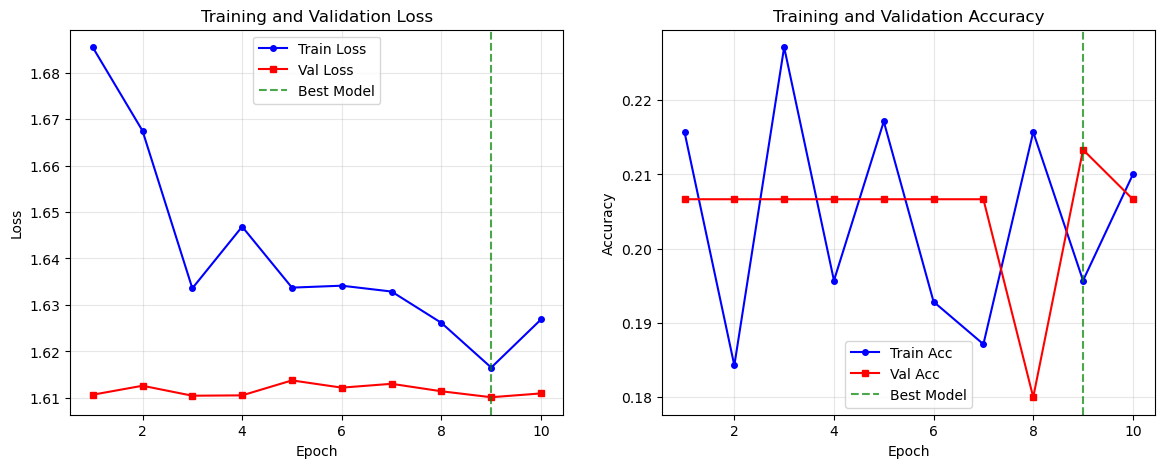

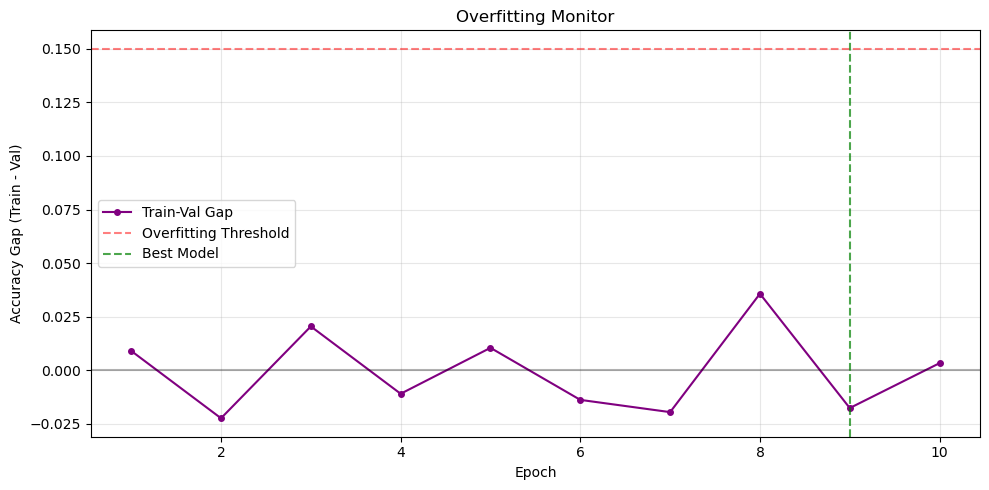

In [36]:
# After training reports
print(f"\n{'='*70}")
print(f"Training Complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"{'='*70}\n")

# Evaluate on test set
print("Evaluating on test set...")
checkpoint = torch.load('best_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = evaluate(model, test_loader, criterion, device, split='Test')
print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"{'='*70}\n")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
ax1.plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', markersize=4)
ax1.plot(epochs_range, history['val_loss'], 'r-s', label='Val Loss', markersize=4)
ax1.axvline(x=checkpoint['epoch']+1, color='g', linestyle='--', alpha=0.7, label='Best Model')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', markersize=4)
ax2.plot(epochs_range, history['val_acc'], 'r-s', label='Val Acc', markersize=4)
ax2.axvline(x=checkpoint['epoch']+1, color='g', linestyle='--', alpha=0.7, label='Best Model')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add gap plot
fig2, ax3 = plt.subplots(1, 1, figsize=(10, 5))
gap = np.array(history['train_acc']) - np.array(history['val_acc'])
ax3.plot(epochs_range, gap, 'purple', marker='o', markersize=4, label='Train-Val Gap')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.axhline(y=0.15, color='red', linestyle='--', alpha=0.5, label='Overfitting Threshold')
ax3.axvline(x=checkpoint['epoch']+1, color='g', linestyle='--', alpha=0.7, label='Best Model')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy Gap (Train - Val)')
ax3.set_title('Overfitting Monitor')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig('training_history.png', dpi=150, bbox_inches='tight')
fig2.savefig('overfitting_monitor.png', dpi=150, bbox_inches='tight')
print("Training curves saved to 'training_history.png' and 'overfitting_monitor.png'\n")


# Example inference: Get embeddings
model.eval()
sample_batch = next(iter(val_loader)).to(device)

with torch.no_grad():
    embeddings = model(sample_batch, return_embeddings=True)
    predictions = model(sample_batch)

print(f"\nEmbedding shape: {embeddings.shape}")
print(f"Predictions shape: {predictions.shape}")
print(f"Predicted classes: {predictions.argmax(dim=1)}")


In [63]:
# 8. Feature Importance Analysis: FeatureImportanceAnalyzer
class FeatureImportanceAnalyzer:
    """
    Analyze which features the model focuses on for predictions
    """
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()

    def integrated_gradients(self, data, target_class=None, steps=50):
        """
        Integrated Gradients: Attribute predictions to input features

        Args:
            data: PyG Data object
            target_class: Target class to explain (if None, uses predicted class)
            steps: Number of interpolation steps
        Returns:
            attributions: (num_nodes, node_feature_dim) importance scores
        """
        self.model.eval()
        data = data.to(self.device)

        # Get prediction
        with torch.no_grad():
            logits = self.model(data)
            if target_class is None:
                target_class = logits.argmax(dim=1).item()

        # Create baseline (zeros)
        baseline = data.clone()
        baseline.x = torch.zeros_like(data.x)

        # Interpolate between baseline and input
        attributions = torch.zeros_like(data.x)

        for step in range(steps):
            alpha = (step + 1) / steps

            # Interpolated input
            interpolated = data.clone()
            interpolated.x = baseline.x + alpha * (data.x - baseline.x)
            interpolated.x.requires_grad = True

            # Forward pass
            logits = self.model(interpolated)

            # Compute gradient
            target_logit = logits[0, target_class]
            target_logit.backward()

            # Accumulate gradients
            attributions += interpolated.x.grad

        # Average and scale by input difference
        attributions = attributions / steps
        attributions = attributions * (data.x - baseline.x)

        return attributions.detach().cpu()

    def attention_weights(self, data):
        """
        Extract attention weights from the model
        Returns attention patterns showing which nodes/features the model focuses on
        """
        self.model.eval()
        data = data.to(self.device)

        attention_maps = {}

        def hook_fn(name):
            def hook(module, input, output):
                if isinstance(output, tuple):
                    # MultiheadAttention returns (output, attention_weights)
                    attention_maps[name] = output[1].detach().cpu()
            return hook

        # Register hooks on attention layers
        hooks = []
        for i, layer in enumerate(self.model.layers):
            hook = layer.self_attn.register_forward_hook(hook_fn(f'layer_{i}'))
            hooks.append(hook)

        # Forward pass
        with torch.no_grad():
            _ = self.model(data)

        # Remove hooks
        for hook in hooks:
            hook.remove()

        return attention_maps

    def pooling_attention_weights(self, data):
        """
        Get attention weights from the pooling layer
        Shows which nodes are most important for final prediction
        """
        self.model.eval()
        data = data.to(self.device)

        if self.model.pooling_type != 'attention':
            raise ValueError("Model must use attention pooling")

        with torch.no_grad():
            x, edge_index, batch = data.x, data.edge_index, data.batch

            # Forward through encoder
            x = self.model.input_proj(x)
            if hasattr(data, 'node_ids') and hasattr(data, 'time_ids'):
                pos_enc = self.model.pos_encoder(x, data.node_ids, data.time_ids)
                x = x + pos_enc

            for layer in self.model.layers:
                x = layer(x, edge_index, batch)

            # Get attention scores
            attention_scores = self.model.attention_pool(x)
            attention_weights = F.softmax(attention_scores, dim=0)

        return attention_weights.detach().cpu()

    def feature_ablation(self, data, target_class=None):
        """
        Measure importance by removing each feature and observing impact

        Returns:
            importance_scores: (node_feature_dim,) - average importance per feature
        """
        self.model.eval()
        data = data.to(self.device)

        # Get baseline prediction
        with torch.no_grad():
            baseline_logits = self.model(data)
            if target_class is None:
                target_class = baseline_logits.argmax(dim=1).item()
            baseline_score = baseline_logits[0, target_class].item()

        num_features = data.x.shape[1]
        importance_scores = torch.zeros(num_features)

        # Ablate each feature
        for feat_idx in range(num_features):
            ablated_data = data.clone()
            ablated_data.x[:, feat_idx] = 0  # Zero out feature

            with torch.no_grad():
                ablated_logits = self.model(ablated_data)
                ablated_score = ablated_logits[0, target_class].item()

            # Importance = drop in score
            importance_scores[feat_idx] = baseline_score - ablated_score

        return importance_scores

    def temporal_importance(self, data, target_class=None):
        """
        Analyze which timesteps are most important

        Returns:
            timestep_importance: (num_timesteps,) - importance per timestep
        """
        self.model.eval()
        data = data.to(self.device)

        if not hasattr(data, 'time_ids'):
            raise ValueError("Data must have time_ids attribute")

        # Get baseline prediction
        with torch.no_grad():
            baseline_logits = self.model(data)
            if target_class is None:
                target_class = baseline_logits.argmax(dim=1).item()
            baseline_score = baseline_logits[0, target_class].item()

        num_timesteps = data.time_ids.max().item() + 1
        timestep_importance = torch.zeros(num_timesteps)

        # Ablate each timestep
        for t in range(num_timesteps):
            ablated_data = data.clone()
            mask = data.time_ids == t
            ablated_data.x[mask] = 0  # Zero out timestep

            with torch.no_grad():
                ablated_logits = self.model(ablated_data)
                ablated_score = ablated_logits[0, target_class].item()

            timestep_importance[t] = baseline_score - ablated_score

        return timestep_importance

    def node_importance(self, data, target_class=None):
        """
        Analyze which spatial nodes are most important

        Returns:
            node_importance: (num_nodes,) - importance per spatial node
        """
        self.model.eval()
        data = data.to(self.device)

        if not hasattr(data, 'node_ids'):
            raise ValueError("Data must have node_ids attribute")

        # Get baseline prediction
        with torch.no_grad():
            baseline_logits = self.model(data)
            if target_class is None:
                target_class = baseline_logits.argmax(dim=1).item()
            baseline_score = baseline_logits[0, target_class].item()

        num_nodes = data.node_ids.max().item() + 1
        node_importance = torch.zeros(num_nodes)

        # Ablate each spatial node
        for node in range(num_nodes):
            ablated_data = data.clone()
            mask = data.node_ids == node
            ablated_data.x[mask] = 0  # Zero out node across all timesteps

            with torch.no_grad():
                ablated_logits = self.model(ablated_data)
                ablated_score = ablated_logits[0, target_class].item()

            node_importance[node] = baseline_score - ablated_score

        return node_importance

    def visualize_importance(self, data, save_path=None):
        """
        Create comprehensive visualization of feature importance
        """
        import matplotlib.pyplot as plt

        # Get various importance measures
        integrated_grads = self.integrated_gradients(data)
        feature_ablation = self.feature_ablation(data)
        temporal_imp = self.temporal_importance(data)
        node_imp = self.node_importance(data)
        pooling_attention = self.pooling_attention_weights(data)

        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle('Feature Importance Analysis', fontsize=16)

        # 1. Average Integrated Gradients per feature
        avg_ig = integrated_grads.abs().mean(dim=0)
        axes[0, 0].bar(range(len(avg_ig)), avg_ig.numpy())
        axes[0, 0].set_title('Integrated Gradients (per feature)')
        axes[0, 0].set_xlabel('Feature Index')
        axes[0, 0].set_ylabel('Importance')

        # 2. Feature Ablation
        axes[0, 1].bar(range(len(feature_ablation)), feature_ablation.numpy())
        axes[0, 1].set_title('Feature Ablation')
        axes[0, 1].set_xlabel('Feature Index')
        axes[0, 1].set_ylabel('Score Drop')

        # 3. Temporal Importance
        axes[0, 2].plot(temporal_imp.numpy(), marker='o')
        axes[0, 2].set_title('Temporal Importance')
        axes[0, 2].set_xlabel('Timestep')
        axes[0, 2].set_ylabel('Importance')
        axes[0, 2].grid(True)

        # 4. Spatial Node Importance
        axes[1, 0].bar(range(len(node_imp)), node_imp.numpy())
        axes[1, 0].set_title('Spatial Node Importance')
        axes[1, 0].set_xlabel('Node ID')
        axes[1, 0].set_ylabel('Importance')

        # 5. Pooling Attention Weights
        pooling_attn_np = pooling_attention.numpy().squeeze()
        axes[1, 1].hist(pooling_attn_np, bins=50)
        axes[1, 1].set_title('Pooling Attention Distribution')
        axes[1, 1].set_xlabel('Attention Weight')
        axes[1, 1].set_ylabel('Count')

        # 6. Heatmap of node features over time
        num_timesteps = data.time_ids.max().item() + 1
        num_nodes = data.node_ids.max().item() + 1
        feature_importance_map = torch.zeros(num_timesteps, num_nodes)

        for t in range(num_timesteps):
            for n in range(num_nodes):
                mask = (data.time_ids == t) & (data.node_ids == n)
                if mask.any():
                    idx = mask.nonzero()[0].item()
                    feature_importance_map[t, n] = integrated_grads[idx].abs().sum()

        im = axes[1, 2].imshow(feature_importance_map.numpy(), aspect='auto', cmap='hot')
        axes[1, 2].set_title('Spatiotemporal Importance Heatmap')
        axes[1, 2].set_xlabel('Spatial Node')
        axes[1, 2].set_ylabel('Timestep')
        plt.colorbar(im, ax=axes[1, 2])

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        return fig



In [3]:
# Example usage of feature importance analysis
print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Load best model (handle MPS compatibility)
checkpoint = torch.load('best_model.pt', map_location=device)
if isinstance(checkpoint, dict):
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(checkpoint)

# Create analyzer
analyzer = FeatureImportanceAnalyzer(model, device)

# Get a sample from validation set
sample_data = val_dataset[0]
sample_data_batch = Batch.from_data_list([sample_data]).to(device)

print("\n1. Integrated Gradients Analysis...")
ig_attributions = analyzer.integrated_gradients(sample_data_batch)
print(f"   Attribution shape: {ig_attributions.shape}")
print(f"   Top 5 important features (by avg absolute attribution):")
avg_attr = ig_attributions.abs().mean(dim=0)
top_features = avg_attr.argsort(descending=True)[:5]
for i, feat_idx in enumerate(top_features):
    print(f"      {i+1}. Feature {feat_idx}: {avg_attr[feat_idx]:.4f}")

print("\n2. Feature Ablation Analysis...")
ablation_scores = analyzer.feature_ablation(sample_data_batch)
print(f"   Top 5 important features (by ablation):")
top_ablation = ablation_scores.argsort(descending=True)[:5]
for i, feat_idx in enumerate(top_ablation):
    print(f"      {i+1}. Feature {feat_idx}: {ablation_scores[feat_idx]:.4f}")

print("\n3. Temporal Importance Analysis...")
temporal_scores = analyzer.temporal_importance(sample_data_batch)
print(f"   Most important timesteps:")
top_times = temporal_scores.argsort(descending=True)[:3]
for i, t in enumerate(top_times):
    print(f"      {i+1}. Timestep {t}: {temporal_scores[t]:.4f}")

print("\n4. Spatial Node Importance Analysis...")
node_scores = analyzer.node_importance(sample_data_batch)
print(f"   Most important nodes:")
top_nodes = node_scores.argsort(descending=True)[:5]
for i, node in enumerate(top_nodes):
    print(f"      {i+1}. Node {node}: {node_scores[node]:.4f}")

print("\n5. Pooling Attention Weights...")
pooling_attn = analyzer.pooling_attention_weights(sample_data_batch)
print(f"   Attention weight statistics:")
print(f"      Mean: {pooling_attn.mean():.6f}")
print(f"      Std: {pooling_attn.std():.6f}")
print(f"      Max: {pooling_attn.max():.6f}")
print(f"      Min: {pooling_attn.min():.6f}")

print("\n6. Creating comprehensive visualization...")
try:
    fig = analyzer.visualize_importance(sample_data_batch,
                                       save_path='feature_importance.png')
    print("   Visualization saved to 'feature_importance.png'")
except ImportError:
    print("   Matplotlib not available, skipping visualization")



FEATURE IMPORTANCE ANALYSIS


NameError: name 'torch' is not defined

In [2]:
# Example visualization usage

print("\n" + "="*60)
print("GRAPH VISUALIZATION")
print("="*60)

# Create visualizer
visualizer = GraphVisualizer(figsize=(15, 10))

# Get sample data
sample_idx = 0
sample_data = val_dataset[sample_idx]
sample_batch = Batch.from_data_list([sample_data]).to(device)

print("\n3. Visualizing model predictions...")
model.eval()
with torch.no_grad():
    pred_logits = model(sample_batch)
    pred_class = pred_logits.argmax(dim=1)
    true_class = sample_data.y.to(device)

fig3 = visualizer.visualize_prediction_comparison(
    sample_data,
    true_class,
    pred_class,
    title="Model Prediction Analysis",
    save_path="prediction_comparison.png"
)

print("\n4. Visualizing node embeddings...")
# Get embeddings from all validation samples
all_embeddings = []
all_labels = []

model.eval()
with torch.no_grad():
    for data in val_dataset:  # First 50 samples
        batch = Batch.from_data_list([data]).to(device)
        emb = model(batch, return_embeddings=True)
        all_embeddings.append(emb)
        all_labels.append(data.y)

all_embeddings = torch.cat(all_embeddings, dim=0)
all_labels = torch.cat(all_labels, dim=0)

fig4 = visualizer.visualize_node_embeddings(
    all_embeddings,
    labels=all_labels,
    title="Graph Embeddings (t-SNE)",
    save_path="embeddings_tsne.png"
)

print("\n5. Visualizing attention weights...")
# Get pooling attention weights
pooling_attention = analyzer.pooling_attention_weights(sample_batch)

# Create attention flow visualization
fig5 = visualizer.visualize_attention_flow(
    sample_data,
    pooling_attention,
    title="Model Attention Flow",
    save_path="attention_flow.png",
    top_k=30
)

print("\nAll visualizations saved!")
print("="*60)



GRAPH VISUALIZATION


NameError: name 'val_dataset' is not defined